<a href="https://colab.research.google.com/github/Philliec459/Open-Source-Petrophysics/blob/main/Klinkenberg/Klinkenberg_Perm_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
using_colab = True

In [2]:
if using_colab:

    #!wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/Sample_data.xlsx'
    !wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/Klinkenberg/Sample_data.xlsx'
    #!wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/photos.ZIP'


    #!pip install altair
    #!pip install panel
    #!pip install pillow

    #!unzip photos


--2024-08-31 13:31:42--  https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/Klinkenberg/Sample_data.xlsx
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Philliec459/Open-Source-Petrophysics/main/Klinkenberg/Sample_data.xlsx [following]
--2024-08-31 13:31:42--  https://raw.githubusercontent.com/Philliec459/Open-Source-Petrophysics/main/Klinkenberg/Sample_data.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10845 (11K) [application/octet-stream]
Saving to: ‘Sample_data.xlsx’

Sample_data.xlsx    100%[===================>]  10.59K  --.-KB/s    in 0s      

2024-08-31 13:31:43 (87

# Klinkenberg Correction to Permeability to air.

## Load Python libraries:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import pearsonr


## Read in Excel file:

In [4]:
excel_file_path = 'Sample_data.xlsx'
data_df = pd.read_excel(excel_file_path)

# Convert columns to numeric, handling non-numeric entries (e.g., '-')
data_df['Perm_He'] = pd.to_numeric(data_df['Perm_He'], errors='coerce')
data_df['Perm_Klink'] = pd.to_numeric(data_df['Perm_Klink'], errors='coerce')

# Drop rows with NaN values in either permeability columns (if any)
data_df = data_df.dropna(subset=['Perm_He', 'Perm_Klink'])


# Cross Plot of Kair to Klinkenberg Perm:

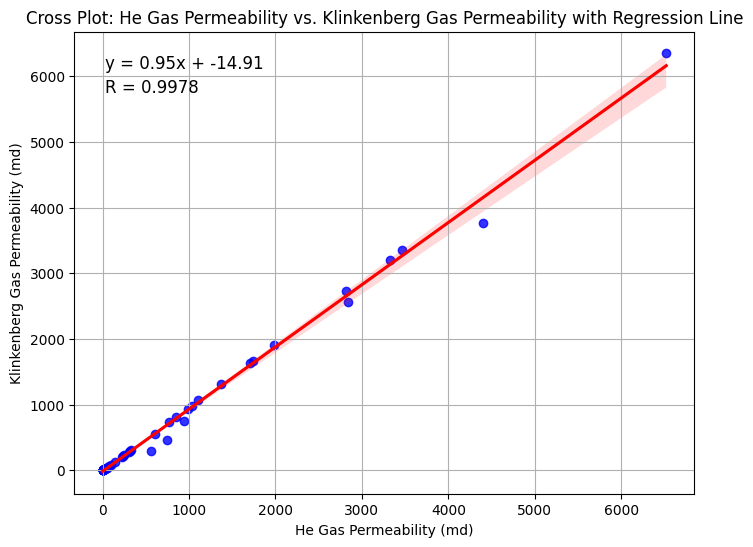

In [5]:
# Create the scatter plot with regression line using seaborn
plt.figure(figsize=(8, 6))
sns.regplot(x='Perm_He', y='Perm_Klink', data=data_df, scatter_kws={'color':'blue'}, line_kws={'color':'red'})

# Fit the linear regression model to get the equation
X = data_df['Perm_He'].values.reshape(-1, 1)
y = data_df['Perm_Klink'].values
model = LinearRegression()
model.fit(X, y)

# Get the slope (m) and intercept (b) for the line equation: y = mx + b
slope = model.coef_[0]
intercept = model.intercept_

# Calculate the Pearson correlation coefficient (R) and its p-value
correlation_coefficient, p_value = pearsonr(data_df['Perm_He'], data_df['Perm_Klink'])

# Display the equation and correlation coefficient on the plot
plt.text(0.05, 0.95, f'y = {slope:.2f}x + {intercept:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'R = {correlation_coefficient:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Label the axes and set the title
plt.xlabel('He Gas Permeability (md)')
plt.ylabel('Klinkenberg Gas Permeability (md)')
plt.title('Cross Plot: He Gas Permeability vs. Klinkenberg Gas Permeability with Regression Line')
plt.grid(True)
plt.show()


# **Summary of Findings:**


At this stage we are only looking at converting our permeability to air to a Klinkenberg perm. Klinkenberg permeability is advised vs. just using a Kari. Jones’ work in RP40 is a great resource for insight into these calculations.

From API RP-40 the key Klinkenberg equation is:

        kg = kl * (1 + b/P_mean)
    
    and
     
        kl = kg / (1 + b/P_mean)


A simple solution is to calculate Kl from Kg using this equation. We have provided a dataset from a Core Lab report with 50 samples where we are assuming that the gas is Helium. I need to check, but I believe that He gas is used with the CMS for both porosity and perm measurements.   

The following are the typical b-factor values for air, helium, and nitrogen:

        Gas	       b-factor (μm)	References
        Air	       0.035 - 0.040	[1, 2, 3]
        Helium     0.200 - 0.250	[1, 2, 4]
        Nitrogen   0.060 - 0.070	[1, 2, 3]

    
    	(b_He_psi = 0.225 for Helium and  14.696 is 1 atmosphere in psi below)

    	b_He_psi = 0.225 * 14.696

    	p_mean_psi = 18

    	Kl_simple = Kair / (1 + b_He_psi / p_mean_psi)

we are using Newton - Raphson inspired by the method published by [PermInc](https://perminc.com/resources/fundamentals-of-fluid-flow-in-porous-media/chapter-2-the-porous-medium/permeability/measurement-permeability/).


In the Appendix of Chapter 6 of RP40, it state:

    	b_He = 16.4*Kl**(-0.382) in psi from equation A-7 of RP-40
   

Since

        Kair = Kl (1 + b/p_mean)

        Kair = Kl  *  (1 +       16.4*Kl**(-0.382)  /  p_mean)

or

        Kair  = Kl    +     Kl * 16.4*Kl**(-0.382) /   p_mean  

        Kair   = Kl  +      16.4*Kl**(1 - 0.382)   /     p_mean

    	Kair   = Kl  +      16.4*Kl**(0.618)        /      p_mean

    	Kair * p_mean  =  Kl * p_mean    +    16.4*Kl**(0.618)

        f(Kl) = Kl * p_mean   +   16.4*Kl**(0.618)     -  Kair * p_mean

        f'(Kl) = df(Kl)/dKl = 16.4 * 0.618 * Kl**{-0.382}      +   p_mean


in an iterative we estimate Kl from:

        Kl_new = Kl_guess - f(Kl) / f'(Kl)

It takes 2 to 3 iterations to satisfy our tolerance limit.


One method seems to under calls in the tight zone and the other overcalls. Below we show Sample Number on the y axis vs. our Kl values.



In [6]:
# Calculate Kl from Kair * 1 atmosphere
b_He_psi = 0.225 * 14.696
p_mean_psi = 18

data_df['Kl_simple'] = data_df['Perm_He']/(1 + b_He_psi / p_mean_psi)

## **Newton Raphson Method(1):**

### Explanation:

1. **Newton-Raphson Method**: The method iteratively solves for the Klinkenberg permeability given the gas permeability, using the formula you provided.

2. **Applying the Function**: The `calculate_Klinkenberg` function is applied to each row in the DataFrame to compute `klinkenberg_perm_calc1`.

3. **Regression Plot**: The `sns.regplot` function is used to create a scatter plot with a fitted regression line.

4. **Linear Regression and Pearson Correlation**: The regression equation and the correlation coefficient are calculated and displayed on the plot.

5. **Error Handling**: Non-numeric values are handled with `pd.to_numeric`, and any resulting NaN values are dropped before plotting and regression.

This will correct the errors and allow us to calculate and plot the Klinkenberg permeability alongside the measured values with the regression line and correlation coefficient.

(1)[PermInc](https://perminc.com/resources/fundamentals-of-fluid-flow-in-porous-media/chapter-2-the-porous-medium/permeability/measurement-permeability/)


## **b_He:**

In [7]:
# RP40 A-7 shows that
# b_HE = 16.4 * Kl**(-0.382) which is close to Cheshires b_He = 17.956 * Kl**(-0.224)
# Notes from RP40 A-7 state that A1 = 5.71 for b_air, or
# b_air = 5.71 * Kl**(-0.382) or


p_mean_psi = 18


# Function to calculate Klinkenberg permeability using Newton-Raphson method
def calculate_Klinkenberg2(K_air_mD, p_mean_psi):
    Kl = K_air_mD / 6  # Initial guess for Kl

    def f(Kl_guess):
        return    16.4 * (Kl_guess ** (1 - 0.382))    +    Kl_guess * p_mean_psi    -    K_air_mD * p_mean_psi

    def df(Kl_guess):
        return     16.4 * 0.618 * Kl_guess ** (-0.382) + p_mean_psi

    tolerance = 1e-6
    max_iterations = 100
    iteration = 0

    while True:
        Kl_new = Kl - f(Kl) / df(Kl)
        if abs(Kl_new - Kl) < tolerance or iteration >= max_iterations:
            break
        Kl = Kl_new
        iteration += 1
        #print(iteration)

    return Kl_new

# Apply the function to each row in the DataFrame
data_df['Kl_NewtonRaphson_He'] = data_df.apply(lambda row: calculate_Klinkenberg2(row['Perm_He'], p_mean_psi), axis=1)



## **b_air:**

In [8]:
# RP40 A-7 shows that
# b_HE = 16.4 * Kl**(-0.382) which is close to Cheshires b_He = 17.956 * Kl**(-0.224)
# Notes from RP40 A-7 state that A1 = 5.71 for b_air, or
# b_air = 5.71 * Kl**(-0.382) or
# 5.71/16.4 = 0.35
# b_air = 0.35 * b_He


p_mean_psi = 18

# Function to calculate Klinkenberg permeability using Newton-Raphson method
def calculate_Klinkenberg(K_air_mD, p_mean_psi):
    Kl = K_air_mD / 2  # Initial guess for Kl

    def f(Kl_guess):
        return 5.71 * (Kl_guess ** (1 - 0.382))    +    Kl_guess * p_mean_psi    -    K_air_mD * p_mean_psi

    def df(Kl_guess):
        return 5.71 * 0.618 * (Kl_guess ** -0.382) + p_mean_psi

    tolerance = 1e-6
    max_iterations = 100
    iteration = 0

    while True:

        Kl_new = Kl - f(Kl) / df(Kl)

        if abs(Kl_new - Kl) < tolerance or iteration >= max_iterations:
            break

        Kl = Kl_new
        iteration += 1

    return Kl_new



# Jones' Rigorous Method for Kl:

In [9]:
'''
The subscript m refers to the measurement gas or condition for the kinkenberg Perm kl using Helium
Subscript c refers to the desired gas or condition for which kg is to be calculated using air for kair

using helium at 72°F. For purposes of comparing this measurement with old data taken on the same formation,
it is desired to calculate kair at a mean pore pressure of 18.0 psia and temperature of 75°F.

   m - The molecular weight of helium is 4.0026, and its viscosity at 72°F is 0.01967 cp.

   c - The average molecular weight of air is 29.0, and its viscosity at 75°F is 0.01837 cp.

   Therefore, from Equation 31, kair at 75°F and 18.0 psia is:
'''

''' Existing kl measurement  '''
#kl = 10.62    # Klinkenberg Permeability using Helium gas
bm = 6.57     # psi for Helium
Tm = 72       # Helium Temperature in DegF for kl
Tmm = (Tm-32)/1.8 + 273.15
μm = (187.0 * (Tmm/273.1)**0.685) * 0.0001
Mm = 4.0026   # Molecular weight of Helium for kl

''' New kair measurement calculation '''

Tc = 75       # Air Temperature in DegF for kg
Tcc = (Tc-32)/1.8 + 273.15
μc = ((14.969 * Tcc**1.5) /(Tcc + 120)) * 0.0001
Mc = 29       # Molecular weight for air for kg
Pmc = 18      # Mean pore pressure for kg


#data_df['Kair_jones'] = data_df['Perm_Klink']* (1 +   (  (bm*μc/μm) * np.sqrt(((Tc+459.7)*Mm)/((Tm+459.7)*Mc))  ) /  Pmc)

data_df['Kl_jones'] = data_df['Perm_He'] / (1 +   (  (bm*μc/μm) * np.sqrt(((Tc+459.7)*Mm)/((Tm+459.7)*Mc))  ) /  Pmc)

data_df.head(10)

,Sample_Number,Porosity,Perm_He,Perm_Klink,Kl_simple,Kl_NewtonRaphson_He,Kl_jones
0,1,28.6,2840.000,2560.000,2399.256568,2719.202967,2520.777832
1,2,11.6,0.386,0.347,0.326096,0.129005,0.342613
2,3,19.9,239.000,223.000,201.909268,213.901730,212.135881
3,4,21.7,1100.000,1070.000,929.289516,1033.559827,976.357611
4,5,8.8,5.370,4.620,4.536622,3.421444,4.766400
5,6,22.8,40.900,35.400,34.552674,32.993884,36.302751
6,7,21.4,745.000,466.000,629.382445,693.098190,661.260382
7,8,24.6,942.000,759.000,795.809749,881.771588,836.117154
8,9,21.6,3.910,2.790,3.303202,2.360763,3.470508
9,10,21.8,101.000,86.200,85.325674,86.642192,89.647381


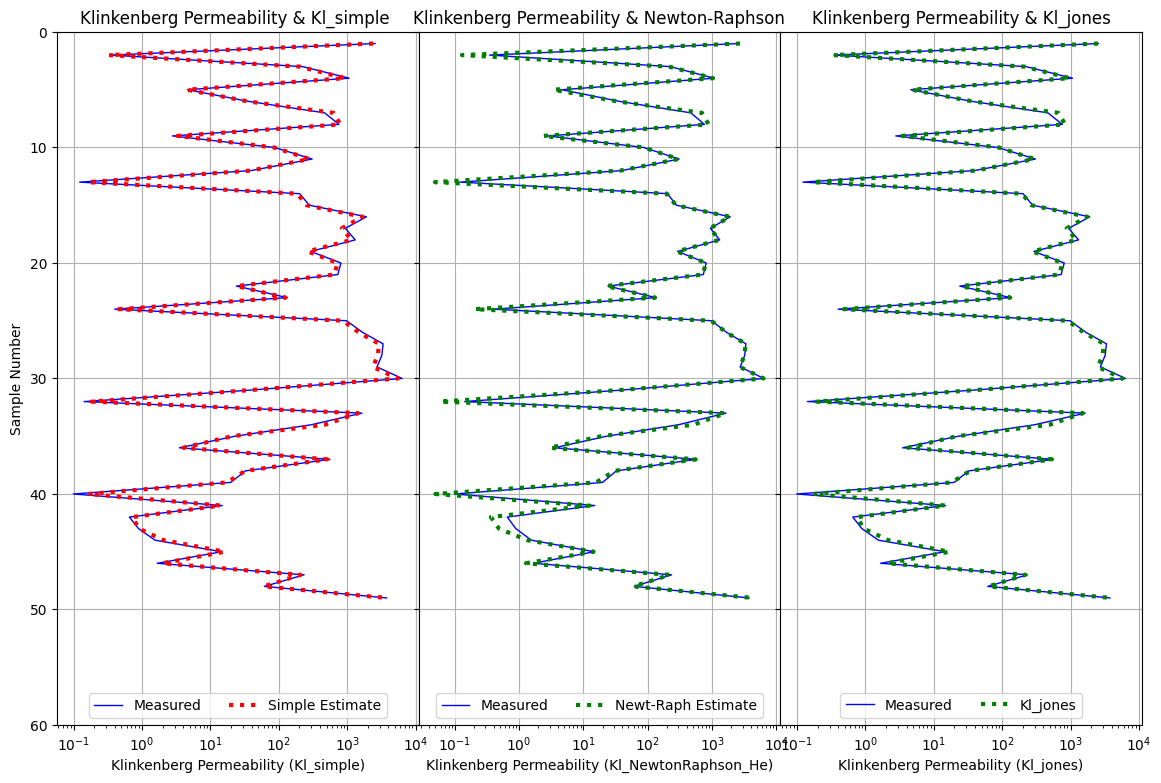

In [10]:

# Create a figure with two subplots side by side
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 9), sharey=True)

# Plot the first track
axs[0].semilogx(data_df['Perm_Klink'], data_df['Sample_Number'], linestyle='-', lw=1, color='blue',label = 'Measured')
axs[0].semilogx(data_df['Kl_simple'], data_df['Sample_Number'], linestyle='dotted', lw=3, color='red',label = 'Simple Estimate')

# Set title and labels for the first track
axs[0].set_title('Klinkenberg Permeability & Kl_simple ')
axs[0].set_xlabel('Klinkenberg Permeability (Kl_simple)')
axs[0].set_ylabel('Sample Number')
axs[0].set_ylim(60, 0)
axs[0].grid()
#axs[0].legend()
axs[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.0), ncol=2)

# Plot the second track
axs[1].semilogx(data_df['Perm_Klink'], data_df['Sample_Number'], linestyle='-', lw=1, color='blue',label = 'Measured')
axs[1].semilogx(data_df['Kl_NewtonRaphson_He'], data_df['Sample_Number'], linestyle='dotted', lw=3, color='green',label = 'Newt-Raph Estimate')
# Set title and labels for the second track
axs[1].set_title('Klinkenberg Permeability & Newton-Raphson')
axs[1].set_xlabel('Klinkenberg Permeability (Kl_NewtonRaphson_He)')
#axs[1].set_ylabel('Sample Number')
axs[1].set_ylim(60, 0)
axs[1].grid()
axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.0), ncol=2)

# Plot the 3rd track
axs[2].semilogx(data_df['Perm_Klink'], data_df['Sample_Number'], linestyle='-', lw=1, color='blue',label = 'Measured')
axs[2].semilogx(data_df['Kl_jones'], data_df['Sample_Number'], linestyle='dotted', lw=3, color='green',label = 'Kl_jones')
# Set title and labels for the second track
axs[2].set_title('Klinkenberg Permeability & Kl_jones')
axs[2].set_xlabel('Klinkenberg Permeability (Kl_jones)')
#axs[2].set_ylabel('Sample Number')
axs[2].set_ylim(60, 0)
axs[2].grid()
axs[2].legend(loc='lower center', bbox_to_anchor=(0.5, -0.0), ncol=2)


# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=0)  # Set wspace to 0 to eliminate the space between subplots


# Adjust layout to prevent overlap
#plt.tight_layout()

# Save the figure as a PDF
plt.savefig('plot_comparison.pdf', format='pdf')



# Show the plot
plt.show()


## Prepare data_df for exporting:

In [11]:
# Define the path for the Excel file
output_excel_path = 'output_Kl_data.xlsx'

# Write the DataFrame to an Excel file
data_df.to_excel(output_excel_path, index=False)

print(f"Data successfully written to {output_excel_path}")


Data successfully written to output_Kl_data.xlsx
